# Percolation on complex networks




## Outline

* Naive implementations of the ordinary bond and site percolation models
* Newman-Ziff algorithm for the ordinary bond and site percolation models
* Explosive percolation


### Libraries used in this notebook

In [1]:
import networkx as nx
import random
import numpy as np
import time
import sys
from scipy.stats import binom


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


from datetime import datetime
random.seed(datetime.now())

## Ordinary bond and site percolation models

The functions below provides naive implementations of the bond and site percolation models. Both functions have two inputs: the graph $G$ where the model is applied to, and the occupation probability $p$. In the ordinary bond percolation, edges are present with probability $p$; in the ordinary site-percolation model, nodes are present with probability $p$.  The output of the functions is a graph corresponding to a single instance of the percolation model with given inputs.

In [2]:
## This function returns an instance of the bond percolation model
## with bond occupation probability p applied to the graph G
def ordinary_bond_percolation (G, p):

    ## create an empty graph
    H = nx.Graph()

    ## nodes are always present
    for n in G:
        H.add_node(n)

    ## edges are present with probability p
    for e in G.edges():
        if random.random() <= p:
            H.add_edge(e[0], e[1])

    return H


## This function returns an instance of the site percolation model
## with site occupation probability p applied to the graph G
def ordinary_site_percolation (G, p):

    ## copy the graph
    H = G.copy()

    ## nodes (and edges attached to them) are present with probability p (or they are deleted with probability 1- p)
    for n in G:
        if random.random() <= 1.0 - p:
            H.remove_node(n)

    return H

## Observables

For a given instance of the percolation model, we determine the size of the connected clusters. Particularly important in the description of the percolation transition is the size of the largest cluster.  

In [3]:
## This function takes as a input a single instance of a percolation model,
## and determines its connected clusters. For simplicity, the function returns
## only the size of the largest and second-largest clusters
def cluster_sizes (H):

    P_infty = 0.0
    S = 0.0

    if len(H) > 0:
        ##determines the connected components (clusters) of the graph
        ##these are stored in the list components, sorted in descending order according to their size
        components = sorted(nx.connected_components(H), key = len, reverse=True)

        if len(components[0]) > 0:
            P_infty = float(len(components[0]))
        if len(components)>1:
            if len(components[1]) > 0:
                S = float(len(components[1]))

    return P_infty, S

## Multiple realizations: average percolation strength and susceptibility

To study numerically a random percolation model on a given network, we typically need to simulate the model multiple times. The function serves to simulate $T$ independent times the same percolation model, and perform statistical estimates of some typical observables used to monitor the percolation transition.


In [4]:
def multiple_realizations_percolation_model (G, p, T, model):

    if model != 'site' and model != 'bond':
        print ('Please specify the percolation model')
        sys.exit(0)


    av = 0.0
    susc = 0.0
    sec = 0.0

    N = float(len(G))

    t = 0
    while t < T:

        if model == 'bond':
            H = ordinary_bond_percolation (G, p)
        if model == 'site':
            H = ordinary_site_percolation (G, p)
        P_infty, S = cluster_sizes (H)

        av += P_infty / N
        susc += (P_infty / N)*(P_infty / N)
        sec += S / N

        t += 1

    av /= T
    susc /= T
    sec /= T
    susc -= av * av
    if av >0.0:
        susc /= av


    return av, susc, sec

In [5]:
##Generate the ER graph
N = 1000
k = 5.0
G = nx.erdos_renyi_graph(N, k / float(N-1))

##this loop serves to include in the graph also nodes with degree equal to zero
for n in range(0, N):
    G.add_node(n)

# ###################################

# ##Generate the CM graph
# def random_pl (kmin, kmax, gamma):
#     tmp_max = np.power(kmax, 1.0-gamma)
#     tmp_min = np.power(kmin, 1.0-gamma)
#     return int(np.power( (tmp_max - (tmp_max - tmp_min) * random.random()), 1.0/(1.0-gamma)))

# N = 1000
# km = 3.0
# kM = int(np.sqrt(N))
# beta = 2.1
# degree_seq = [random_pl (km, kM, beta) for n in range(0,N)]
# if sum(degree_seq)%2 !=0:
#     r = random.randint(0, N)
#     degree_seq[r] += 1
# G = nx.Graph()
# G = nx.configuration_model(degree_seq)
# G = nx.Graph(G)
# G.remove_edges_from(nx.selfloop_edges(G))

# ##this loop serves to include in the graph also nodes with degree equal to zero
# for n in range(0, N):
#     G.add_node(n)

In [6]:
##Apply percolation models to the graph, and monitor observables as functions of the occupation probability p

T = 100
dp = 0.05
p_vec = np.arange(0.0, 1.0+dp, dp)

bond_perc = []
site_perc = []

for i in range (0, len(p_vec)):
    p = p_vec[i]
    bond_perc.append(multiple_realizations_percolation_model (G, p, T, 'bond'))
    site_perc.append(multiple_realizations_percolation_model (G, p, T, 'site'))



## Visualize the results

The code below serves only to visualize the behavior of the various observable as a function $p$.

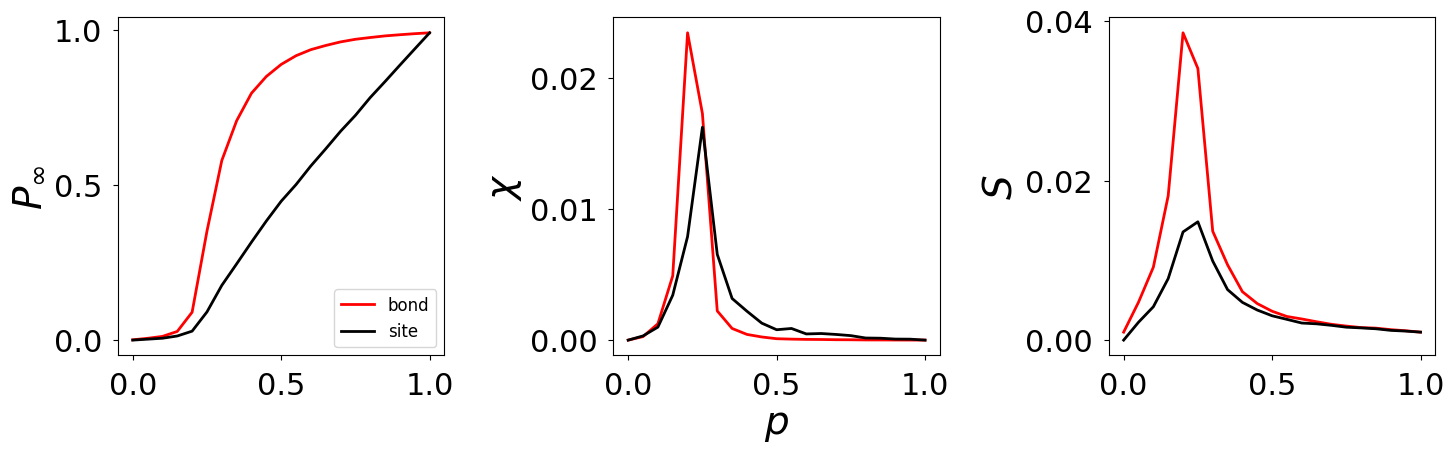

In [7]:
def add_to_plot (x_val, y_val, col, ax, color, label):

    x = []
    y = []

    for i in range (0, len(x_val)):
        x.append(x_val[i])
        y.append(y_val[i][col])


    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(15,5)
plt.rc('text', usetex=False)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,3,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,3,2)
ax2.set_ylabel('$\\chi$', fontsize=28)
ax3 = fig.add_subplot(1,3,3)
ax3.set_ylabel('$S$', fontsize=28)


ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (p_vec, bond_perc, 0, ax1, 'red', 'bond')
add_to_plot (p_vec, site_perc, 0, ax1, 'black', 'site')


add_to_plot (p_vec, bond_perc, 1, ax2, 'red', 'bond')
add_to_plot (p_vec, site_perc, 1, ax2, 'black', 'site')


add_to_plot (p_vec, bond_perc, 2, ax3, 'red', 'bond')
add_to_plot (p_vec, site_perc, 2, ax3, 'black', 'site')






ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)
ax3.locator_params(nbins=4)



fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()

# Newman-Ziff algorithm

The following code implements the Newman-Ziff (NZ) algorithm for ordinary percolation models. The NZ algorithm allows to draw the entire percolation diagram more efficiently than the naive implementations provided above. The ZN algorithm (or variants of the NZ algorithm) is used very often in percolation models on networks.

For more details on the NZ algorithm, see the original paper

M.E.J. Newman and R.M Ziff,
[Efficient Monte Carlo Algorithm and High-Precision Results for Percolation](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.85.4104),
Phys. Rev. Lett. 85, 4104 (2000)


Our implementation relies on three main functions: 1) One function takes care of (potential) mergers among clusters induced by the addition of single edges; 2) One function regulates what edges are sequentially added (site- and bond-percolation models differ in this respect); 3) One function repeats $T$ independent times the NZ algorithm.

In [8]:
# Input:
# n: Node whose root is to be found.
# root: Dictionary where each key is a node and the value is a list containing the root node and the size of the cluster.
# Output: Returns the root node and the size of that cluster.

def newman_ziff_find_root (n, root):
    if root[n][0] == n:
        return root[n]
    return newman_ziff_find_root (root[n][0], root)

# merges two clusters if they are different, and returns the new root. n and m are the points to be merged.
def newman_ziff_merge_clusters (n, m, root):

    rn, sn = newman_ziff_find_root (n, root)
    rm, sm = newman_ziff_find_root (m, root)

    if rn != rm:

        if sn > sm:
            root[rm] = [rn, 1]
            root[rn] = [rn, sn+sm]
            return root[rn]

        root[rn] = [rm, 1]
        root[rm] = [rm, sn+sm]
        return root[rm]

    return root[rn]



# bond percolation on a graph G
def newman_ziff_bond_percolation (G, res_av, res_susc):

    N = float(len(G))

    list_of_edges = []
    for e in G.edges():
        list_of_edges.append([e[0], e[1]])
    random.shuffle(list_of_edges)     # Shuffles the nodes of G to make it random

    root = {}
    for n in G:
        root[n] = [n, 1]

    # P_infty: max cluster size
    P_infty = 1

    # res_av: average cluster size
    # res_susc: average suscebility
    # randomly add bonds to merge
    for i in range(0, len(list_of_edges)):
            n = list_of_edges[i][0]
            m = list_of_edges[i][1]


            q, P = newman_ziff_merge_clusters (n, m, root)
            if P > P_infty:
                P_infty = P
            res_av[i] += P_infty / N
            res_susc[i] += (P_infty / N) * (P_infty / N)


def newman_ziff_site_percolation (G, res_av, res_susc):

    N = float(len(G))

    list_of_nodes = list(G.nodes())
    random.shuffle(list_of_nodes)
    present = {}
    for n in list_of_nodes:
        present[n] = 0

    root = {}
    P_infty = 1

    for i in range(0, len(list_of_nodes)):
        n = list_of_nodes[i]
        present[n] = 1
        root[n] = [n, 1]
        for m in G.neighbors(n):
            if present[m] > 0:
                q, P = newman_ziff_merge_clusters (n, m, root)
                if P > P_infty:
                    P_infty = P
        res_av[i] += P_infty / N
        res_susc[i] += (P_infty / N) * (P_infty / N)


def multiple_newman_ziff_percolation (G, T, model):

    if model == 'bond':
        res_av = np.zeros(G.number_of_edges())
        res_susc = np.zeros(G.number_of_edges())

        # T: number of simulations
        for t in range(0, T):
            newman_ziff_bond_percolation (G, res_av, res_susc)

        # take average of the results accumulated
        for i in range(0, len(res_av)):
            res_av[i] /= float(T)
            res_susc[i] /= float(T)
            res_susc[i] -= res_av[i] * res_av[i]
            if res_av[i] >0.0:
                res_susc[i] /= res_av[i]

    if model == 'site':
        res_av = np.zeros(G.number_of_nodes())
        res_susc = np.zeros(G.number_of_nodes())
        for t in range(0, T):
            newman_ziff_site_percolation (G, res_av, res_susc)
        for i in range(0, len(res_av)):
            res_av[i] /= float(T)
            res_susc[i] /= float(T)
            res_susc[i] -= res_av[i] * res_av[i]
            if res_av[i] >0.0:
                res_susc[i] /= res_av[i]



    return res_av, res_susc

In [ ]:
time_complex = []
for i in (20, 40, 80, 100, 200, 400, 800, 1000, 1200, 1600, 2000, 2400):

    N = i

    ##Generate the ER graph
    #N = 1000
    k = 5.0
    G = nx.erdos_renyi_graph(N, k / float(N-1))

    ##this loop serves to include in the graph also nodes with degree equal to zero
    for n in range(0, N):
        G.add_node(n)

    T = 100
    dp = 0.05
    p_vec = np.arange(0.0, 1.0+dp, dp)

    bond_perc = []
    site_perc = []

    for i in range (0, len(p_vec)):
        p = p_vec[i]
        bond_perc.append(multiple_realizations_percolation_model (G, p, T, 'bond'))
        site_perc.append(multiple_realizations_percolation_model (G, p, T, 'site'))


    tic = time.time()
    res_av_bond, res_susc_bond = multiple_newman_ziff_percolation (G, T, 'bond')
    toc = time.time()

    print("For N=", N, "the average time to run is", (toc-tic)/(100*T))
    time_complex.append([N, (toc-tic)/(100*T)])


In [10]:
import plotly.express as px
import plotly.io as pio
import pandas as pd

# plot time_complex

# Convert list to pandas DataFrame
df = pd.DataFrame(time_complex, columns=['N', 'Time taken'])

# Set default theme to dark
pio.templates.default = "plotly_dark"

# Create scatter plot
fig = px.scatter(df, x='N', y='Time taken', title='Time Complexity Scatter Plot', trendline='ols')

# Show the plot
fig.show()


In [11]:
## Simulations for bond percolation
res_av_bond, res_susc_bond = multiple_newman_ziff_percolation (G, T, 'bond')


In [13]:
## Simulations for site percolation
res_av_site, res_susc_site = multiple_newman_ziff_percolation (G, T, 'site')

## Visualize the results

The code below serves only to visualize the behavior of the various observable as a function $p$.

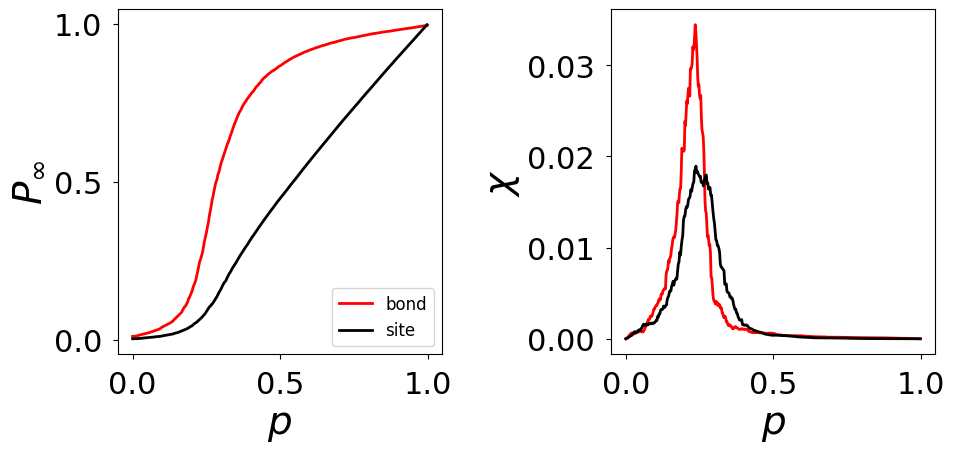

In [14]:
def add_to_plot (val, ax, color, label):

    x = []
    y = []

    for i in range (0, len(val)):
        x.append(float(i)/float(len(val)))
        y.append(val[i])


    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=False)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('$\\chi$', fontsize=28)


ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (res_av_bond, ax1, 'red', 'bond')
add_to_plot (res_av_site, ax1, 'black', 'site')


add_to_plot (res_susc_bond, ax2, 'red', 'bond')
add_to_plot (res_susc_site, ax2, 'black', 'site')







ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)


fig.tight_layout()
fig.savefig('fig1.pdf')
plt.show()

## From the microcanonical to the canonical ensemble

The functions reported above provides numerical estimates of observables for a given number of occupied sites or bonds. In order to produce results that are actually equivalenet to ordinary percolation models, we need to estimate the values of the observables as a functions of the occupation probability $p$. The function below is devoted to it.

In [15]:
def nz_micro_to_canonical (res_av_micro, res_susc_micro, dp):

    threshold = 1.0e-6

    N = len(res_av_micro)

    p_vec = np.arange(0.0, 1.0+dp, dp)

    res_av_can = []
    res_susc_can = []


    for i in range(0, len(p_vec)):

        tmp_av = 0.0
        tmp_susc = 0.0
        norm = 0.0


        p = p_vec[i]

        n_c = int(float(N) * p) -1
        tmp = binom.pmf(n_c, N, p)
        tmp_av += tmp * res_av_micro[n_c]
        tmp_susc += tmp * res_susc_micro[n_c]
        norm += tmp

        for j in range(n_c+1, N):
            tmp = binom.pmf(j, N, p)
            if tmp > threshold:
                tmp_av += tmp * res_av_micro[j]
                tmp_susc += tmp * res_susc_micro[j]
                norm += tmp
            else:
                j = N

        for j in range(n_c-1, 0, -1):
            tmp = binom.pmf(j, N, p)
            if tmp > threshold:
                tmp_av += tmp * res_av_micro[j]
                tmp_susc += tmp * res_susc_micro[j]
                norm += tmp
            else:
                j = 0


        res_av_can.append(tmp_av/norm)
        res_susc_can.append(tmp_susc/norm)


    return p_vec, res_av_can, res_susc_can

In [16]:
bond_p_vec, bond_av_can, bond_susc_can = nz_micro_to_canonical (res_av_bond, res_susc_bond, 0.01)

In [17]:
site_p_vec, site_av_can, site_susc_can = nz_micro_to_canonical (res_av_site, res_susc_site, 0.01)

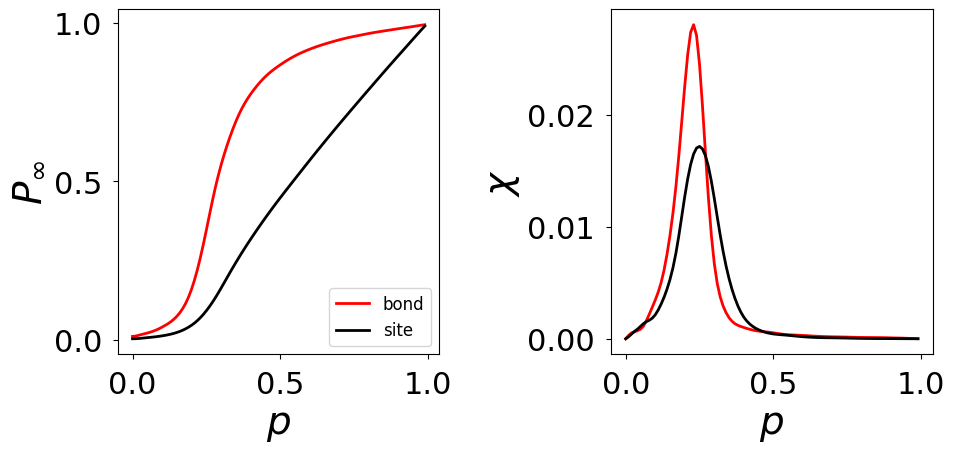

In [18]:
def add_to_plot (x, y, ax, color, label):

    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=False)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('$\\chi$', fontsize=28)


ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (bond_p_vec, bond_av_can, ax1, 'red', 'bond')
add_to_plot (site_p_vec, site_av_can, ax1, 'black', 'site')


add_to_plot (bond_p_vec, bond_susc_can, ax2, 'red', 'bond')
add_to_plot (site_p_vec, site_susc_can, ax2, 'black', 'site')







ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)


fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()

## Explosive percolation

A minimal modification of the Newman-Ziff algorithm is used in the "explosive" percolation model. For more details see

D. Achlioptas, R. M. D'Souza, J. Spencer,
[Explosive Percolation in Random Networks](http://science.sciencemag.org/content/323/5920/1453),
Science 323, 1453-1455 (2009)

F. Radicchi and S. Fortunato,
[Explosive Percolation in Scale-Free Networks](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.168701),
Phys. Rev. Lett. 103, 168701 (2010)

In [20]:
def test_merger (n, m, root):
    rn, sn = newman_ziff_find_root (n, root)
    rm, sm = newman_ziff_find_root (m, root)
    return sn*sm





def explosive_percolation (G, res_av, res_susc):

    N = float(len(G))

    list_of_edges = []
    for e in G.edges():
        list_of_edges.append([e[0], e[1]])

    root = {}
    for n in G:
        root[n] = [n, 1]


    P_infty = 1
    i = 0
    while len(list_of_edges) >= 2:

        e1 = random.randint(0, len(list_of_edges)-1)
        e2 = e1
        while e2 == e1:
            e2 = random.randint(0, len(list_of_edges)-1)

        ##test 1
        n = list_of_edges[e1][0]
        m = list_of_edges[e1][1]
        s1 = test_merger (n, m, root)

        ##test 1
        n = list_of_edges[e2][0]
        m = list_of_edges[e2][1]
        s2 = test_merger (n, m, root)


        if s1 < s2:
            n = list_of_edges[e1][0]
            m = list_of_edges[e1][1]
            list_of_edges[e1][0] = list_of_edges[len(list_of_edges)-1][0]
            list_of_edges[e1][1] = list_of_edges[len(list_of_edges)-1][1]
        else:
            n = list_of_edges[e2][0]
            m = list_of_edges[e2][1]
            list_of_edges[e2][0] = list_of_edges[len(list_of_edges)-1][0]
            list_of_edges[e2][1] = list_of_edges[len(list_of_edges)-1][1]

        del list_of_edges[-1]




        q, P = newman_ziff_merge_clusters (n, m, root)
        i = i + 1

        if P > P_infty:
            P_infty = P
        res_av[i] += P_infty / N
        res_susc[i] += (P_infty / N) * (P_infty / N)


def multiple_explosive_percolation (G, T):


    res_av = np.zeros(G.number_of_edges())
    res_susc = np.zeros(G.number_of_edges())
    for t in range(0, T):
        explosive_percolation (G, res_av, res_susc)
    for i in range(0, len(res_av)):
        res_av[i] /= float(T)
        res_susc[i] /= float(T)
        res_susc[i] -= res_av[i] * res_av[i]
        if res_av[i] >0.0:
            res_susc[i] /= res_av[i]




    return res_av, res_susc

In [21]:
## Simulations for bond percolation
explosive_av, explosive_susc = multiple_explosive_percolation (G, T)

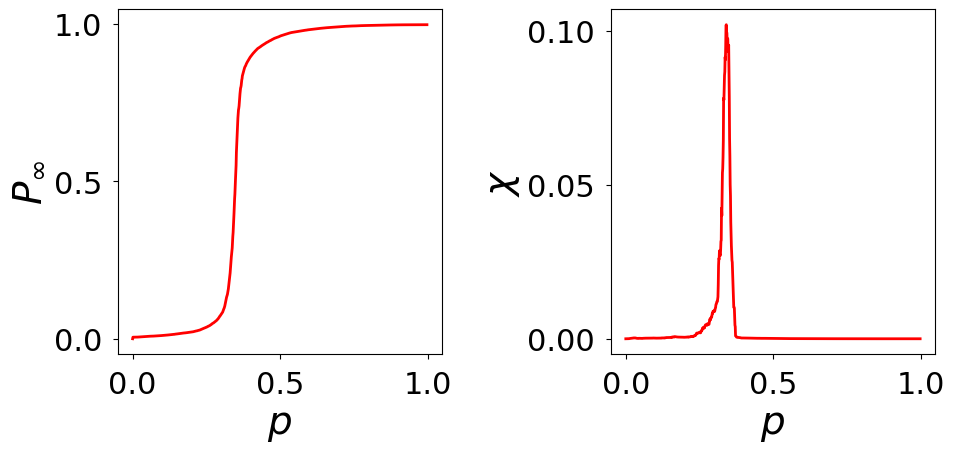

In [22]:
def add_to_plot (val, ax, color, label):

    x = []
    y = []

    for i in range (0, len(val)-2):
        x.append(float(i)/float(len(val)))
        y.append(val[i])


    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=False)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('$\\chi$', fontsize=28)


ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)






add_to_plot (explosive_av, ax1, 'red', '')


add_to_plot (explosive_susc, ax2, 'red', '')







#ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)


fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()